<a href="https://www.kaggle.com/code/typicalmango/nutrient-label-ocr?scriptVersionId=182592112" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import easyocr

In [2]:
img_path = "/kaggle/input/food-nutrition-labels/labels/1.jpg"

In [3]:
def show_img(path, size = (5, 5)):
    fig, ax = plt.subplots(figsize=size)
    ax.imshow(plt.imread(path))
    ax.axis('off')
    plt.show()

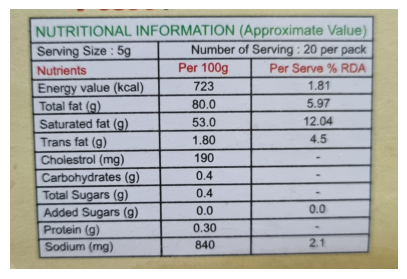

In [4]:
show_img(img_path)

In [5]:
# Resize image
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

# Display grey scale image
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

# Display RGB colour image
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# We will use approxPolyDP for approximating more primitive contour shape consisting of as few points as possible
# Approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

def get_rectangular_contours(contours):
    # Approximates provided contours and returns only those which have 4 vertices
    res = []
    for contour in contours:
        hull = cv2.convexHull(contour)
        peri = cv2.arcLength(hull, closed=True)
        approx = cv2.approxPolyDP(hull, 0.04 * peri, closed=True)
        if len(approx) == 4:
            res.append(approx)
    return res

# Find 4 points of table
def get_table_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is table's rectangle
        if len(approx) == 4:
            return approx
        
# Convert 4 points into lines / rect      
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

# Original table with warpped perspective
def warp_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

def plot_gray(image):
    plt.figure(figsize=(5, 5))
    return plt.imshow(image, cmap='Greys_r')

def plot_rgb(image):
    plt.figure(figsize=(5,5))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

def find_amounts(text):
    amounts = re.findall(r'\d+\.\d{2}\b', text)
    floats = [float(amount) for amount in amounts]
    unique = list(dict.fromkeys(floats))
    return unique

# Plot EasyOCR output
def plot_extractions(img, results):
    fig, ax = plt.subplots()

    ax.imshow(img, cmap='Greys_r')
    for bbox, text, conf in results:
        a, b, c, d = bbox
        rect = patches.Rectangle((a[0], a[1]), c[0]-a[0], c[1]-a[1], linewidth=1, edgecolor='r', facecolor='none', label=text)
        ax.add_patch(rect)
    pos = ax.get_position()
    ax.axis('off')
    ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)
    plt.show()


# Cell by Cell Extraction of output
def extract_text_by_cell(results, columns, thresh=0.5):
    res_cols = []
    res_rows = [0]
    for i in range(len(results)):
        (a, b, c, d), text, conf = results[i]
        x1, x2, = a[0], c[0]
        flag = True
        for col in range(len(columns)-1):
            # if x1 > columns[col] and x2 < columns[col+1]:
            if x2 < columns[col+1]:
                flag = False
                res_cols.append(col)
                break
        if flag:
            drop_val.append(i)
            res_cols.append(-1)
    #np.delete(results, drop_val)
    extracted_text = []
    row = 0
    prev_bbox, prev_text, prev_conf = results[0]
    prev_a, prev_b, prev_c, prev_d = prev_bbox
    prev_y = prev_a[1] # horizontal
    prev_height = abs(prev_a[1]-prev_c[1])
    for i in range(1, len(results)):
        if res_cols[i] == -1:
            res_rows.append(-1)
            continue
        bbox, text, conf = results[i]
        a, b, c, d = bbox
        x1, x2 = a[0], c[0]
        y = b[1]
        if abs(y-prev_y) < thresh * prev_height:
            res_rows.append(row)
        else:
            row+=1
            res_rows.append(row)
        prev_bbox, prev_text = bbox, text
        prev_y = y
        prev_height = abs(a[1]-c[1])

    prev_col = 0
    prev_row = res_rows[0]
    prev_bbox, prev_text, prev_conf = results[0]
    cell_text = ""
    row_text = []
    for i in range(len(results)):
        bbox, text, conf = results[i]
        row = res_rows[i]
        col = res_cols[i]
        if row == prev_row:
            if col == prev_col:
                cell_text += text+" "
            else:
                while col-prev_col != 1 and col>prev_col:
                    row_text.append(cell_text)
                    cell_text = ""
                    prev_col+=1
                row_text.append(cell_text)
                cell_text = text+" "
        else:
            while col-prev_col != 1 and col>prev_col:
                row_text.append(cell_text)
                cell_text = ""
                prev_col+=1
            row_text.append(cell_text)
            cell_text = text+" "
            extracted_text.append(row_text)
            cell_text = text+" "
            row_text = []
        prev_col = col
        prev_row = row
        prev_bbox, prev_text, prev_conf = bbox, text, conf
    return extracted_text

In [6]:
image = cv2.imread(img_path)

#Downscale image.
#Finding table contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

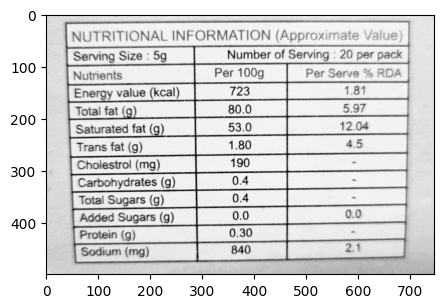

In [7]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

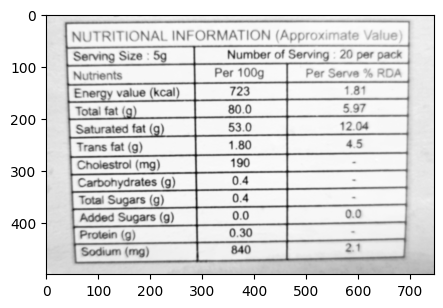

In [8]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

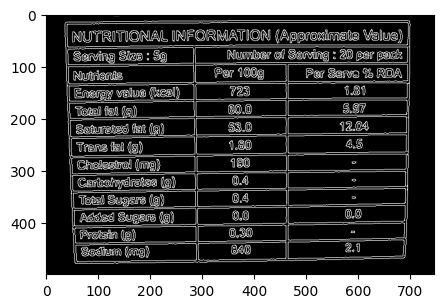

In [9]:
edged = cv2.Canny(blurred, 50, 125, apertureSize=3)
plot_gray(edged)

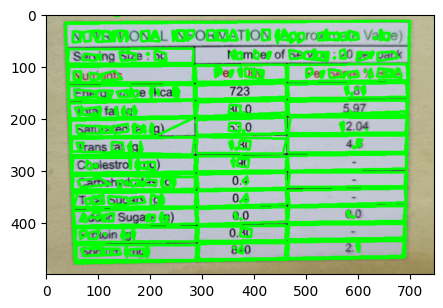

In [10]:
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# quad approximation for all contours
contours = get_rectangular_contours(contours)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

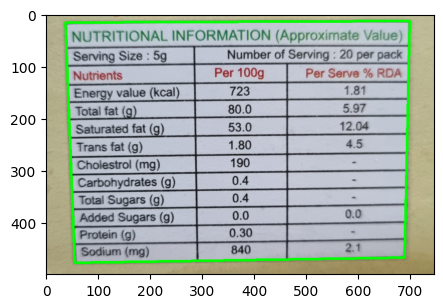

In [11]:
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:1]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [12]:
table_contour = get_table_contour(largest_contours)

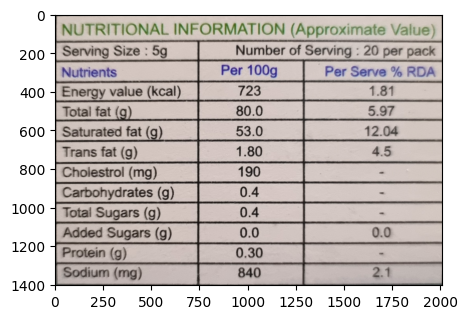

In [13]:
scanned = warp_perspective(original.copy(), contour_to_rect(table_contour))
plt.figure(figsize=(5, 4))
plt.imshow(scanned)

<Figure size 1600x1000 with 0 Axes>

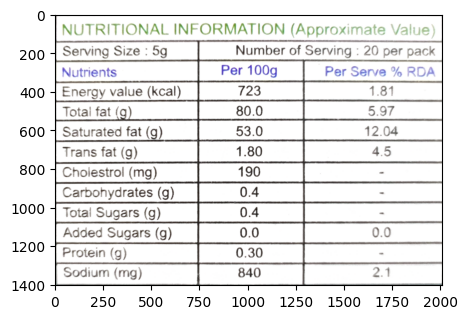

In [14]:
blur = cv2.GaussianBlur(scanned, (0,0), sigmaX=33, sigmaY=33)
divided = cv2.divide(scanned, blur, scale=255)
plt.figure(figsize=(16,10))
plot_gray(divided)

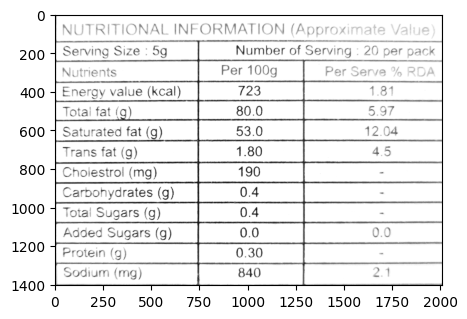

In [15]:
gray = cv2.cvtColor(divided, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

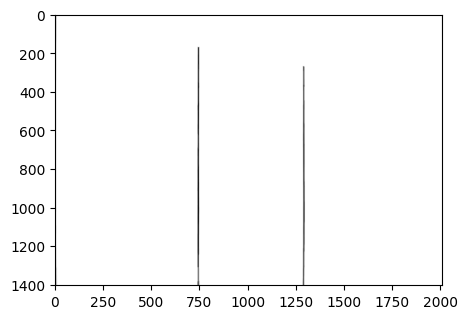

In [16]:
kernel_vert = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(1, 70))
dilated_vert = cv2.dilate(gray, kernel_vert)
plot_gray(dilated_vert)

In [17]:
h, w = dilated_vert.shape
columns = [0]

row = dilated_vert[h//2]
j = 0
while j < w:
    px = row[j]
    if px < 127:
        line_centre = 0
        centre_count = 0
        count = 0
        while j < w and count < w//100+1:
            px = row[j]
            if px < 127:
                line_centre += j
                centre_count += 1
            else:
                count+=1
            j+=1
        line_centre /= centre_count   
        columns.append(line_centre)
    j+=1
columns.append(w)
print("column coordinates:",columns)

column coordinates: [0, 742.5, 1289.0, 2011]


In [18]:
reader = easyocr.Reader(['en'], gpu = False)

In [19]:
results = reader.readtext(gray)

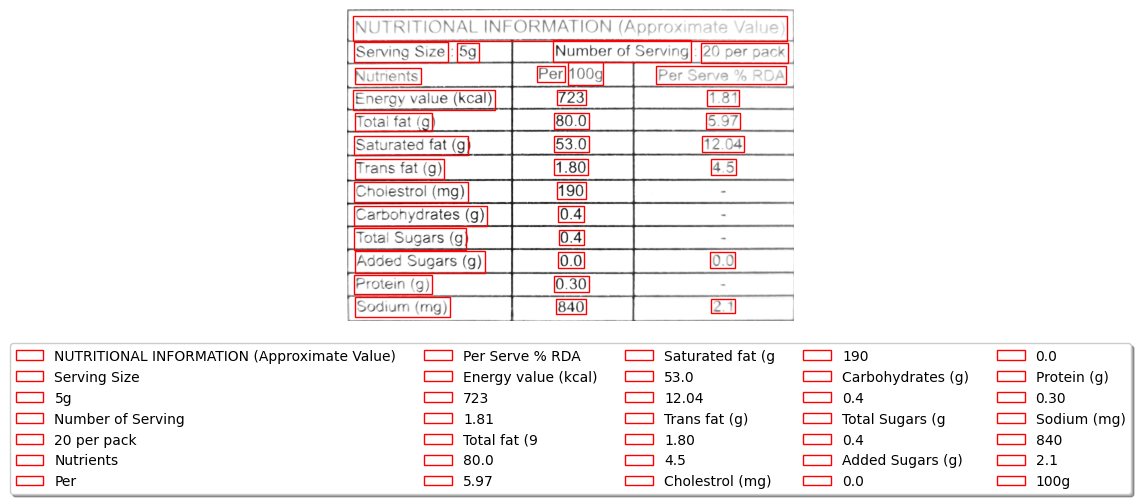

In [20]:
plot_extractions(gray, results)

In [21]:
extracted_text = extract_text_by_cell(results, columns, 0.3)

In [22]:
table = pd.DataFrame(extracted_text).fillna("-")
table

,0,1,2
0,,,NUTRITIONAL INFORMATION (Approximate Value)
1,Serving Size 5g,,Number of Serving 20 per pack
2,Nutrients,Per,Per Serve % RDA
3,Energy value (kcal),723,1.81
4,Total fat (9,80.0,5.97
5,Saturated fat (g,53.0,12.04
6,Trans fat (g),1.80,4.5
7,Cholestrol (mg),190,-
8,Carbohydrates (g),0.4,-
9,Total Sugars (g,0.4,-


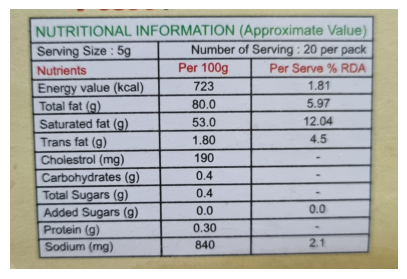

In [23]:
show_img(img_path)

# Known Limitations:
### - lack of standardization of food labels
### - if label is on highly curved surface, OCR fails
### - if label isnt bounded by a clear box, OCR fails